# Table of contents
[1. Install scikit-learn & required library]($.#1-install-scikit-learn--required-library)<br>
[2. Preparing the datasets](#2-preparing-the-datasets)<br>
[3. Prepare, Building and Evaluating with the decision tree](#3-prepare-building-and-evaluating-with-the-decision-tree)<br>
⠀⠀[3.1 Prepare the splits for the building of the decision tree](#31-prepare-the-splits-for-the-building-of-the-decision-tree)<br>
⠀⠀[3.2 Training and evaluate](#32-training-and-evaluate)<br>
⠀⠀[3.3 Run all splits](#33-run-all-splits)<br>
⠀⠀[3.4 Depth analysis](#34-depth-analysis)<br>

# 1. Install scikit-learn & required library
This project require numpy, pandas, matplotlib, graphviz, IPython... and scikit-learn be installed. Run the following code to install the requirements.

In [117]:
!python -m pip install -U scikit-learn
!python -m pip install matplotlib
!python -m pip install graphviz
!python -m pip install IPython

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# 2. Preparing the datasets
The following code will download the dataset heart-disease from URL.

• Binary class dataset: The [UCI Heart Disease dataset](https://archive.ics.uci.edu/dataset/45/heart+disease) is used for classifying whether a
patient has a heart disease or not based on age, blood pressure, cholesterol level, and other
medical indicators. This dataset includes 303 samples, with labels indicating presence (1) or
absence (0) of heart disease. Experiments with the Cleveland database have concentrated on
simply attempting to distinguish presence (values 1,2,3,4) from absence (value 0).

The dataset will be fetched from URL then split into `feature` and `label`.

In [118]:
heart_disease_db_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
heart_disease_columns = ["age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal", "num"]
dataset_name = "Heart Disease"

def split_dataset(_dataset: pd.DataFrame, targets: list):
	"""
	Split input dataset into feature and target by input targets
	:return: dict["feature"]
	"""
	existing_columns = [col for col in targets if col in _dataset.columns]
	missing_columns = [col for col in targets if col not in _dataset.columns]
	if missing_columns:
		print("These columns are not found in the dataset:", missing_columns)
	return {
		"feature": _dataset.drop(existing_columns, axis=1),
		"target": _dataset[existing_columns],
	}

# fetch dataset from url
raw_heart_db = pd.read_csv(heart_disease_db_url, names=heart_disease_columns)
raw_heart_db = raw_heart_db.replace('?', np.nan)
raw_heart_db = raw_heart_db.dropna()
raw_heart_db = raw_heart_db.astype(float)
raw_heart_db['num'] = raw_heart_db['num'].apply(lambda x: 1 if x > 0 else 0) # labelling the target 'num'

dataset = split_dataset(raw_heart_db, targets=['num'])  # adding columns name

# 3. Prepare, Building and Evaluating with the decision tree
> Required to run the code at [Section #2](#2-preparing-the-datasets) before continue!

### 3.1 Prepare the splits for the building of the decision tree
This following code splits the dataset into multiple splits with defined ratio.
The splits are structured as following `[ratio: float => (feature_train, feature_test, label_train, label_test)]`

In [119]:
import sys
from sklearn.model_selection import train_test_split
import os

split_ratios = [0.6, 0.4, 0.2, 0.1] # train/test 60/40 40/60 80/20 90/10
# random_seed = 42                    # 42 for testing and cultural reference :)
random_seed = None                  # None for random seed
class_name = ["No Decease", "Decease"]

def tee_print(message, file):
	print(message)            # print to console
	print(message, file=file) # print to log file

def snake_case(s: str) -> str:
	return ''.join('_' if c.isspace() else c.lower() for c in s)

snake_cased_dataset_name = snake_case(dataset_name)
os.makedirs(f"output/depth/{snake_cased_dataset_name}", exist_ok=True)
os.makedirs(f"output/splits/{snake_cased_dataset_name}", exist_ok=True)

def prepare_dataset(features, labels, test_size, seed=None):
	"""
	:param features: input features
	:param labels: input labels
	:param test_size: Test size ratio (test/(train+test))
	:param seed: seed used for random, default=None for random seed
	:return: feature_train, feature_test, label_train, label_test
	"""
	return train_test_split(features, labels, test_size=test_size, stratify=labels, random_state=seed, shuffle=True)

def prepare_all_splits(features, labels, seed=None):
    splits = {}
    for split_ratio in split_ratios:
        splits[split_ratio] = prepare_dataset(features, labels, test_size=split_ratio, seed=seed)
    return splits

dataset_splits = prepare_all_splits(dataset['feature'], dataset['target'], seed=random_seed)

#### 3.1.a Visualize the class distributions in all datasets

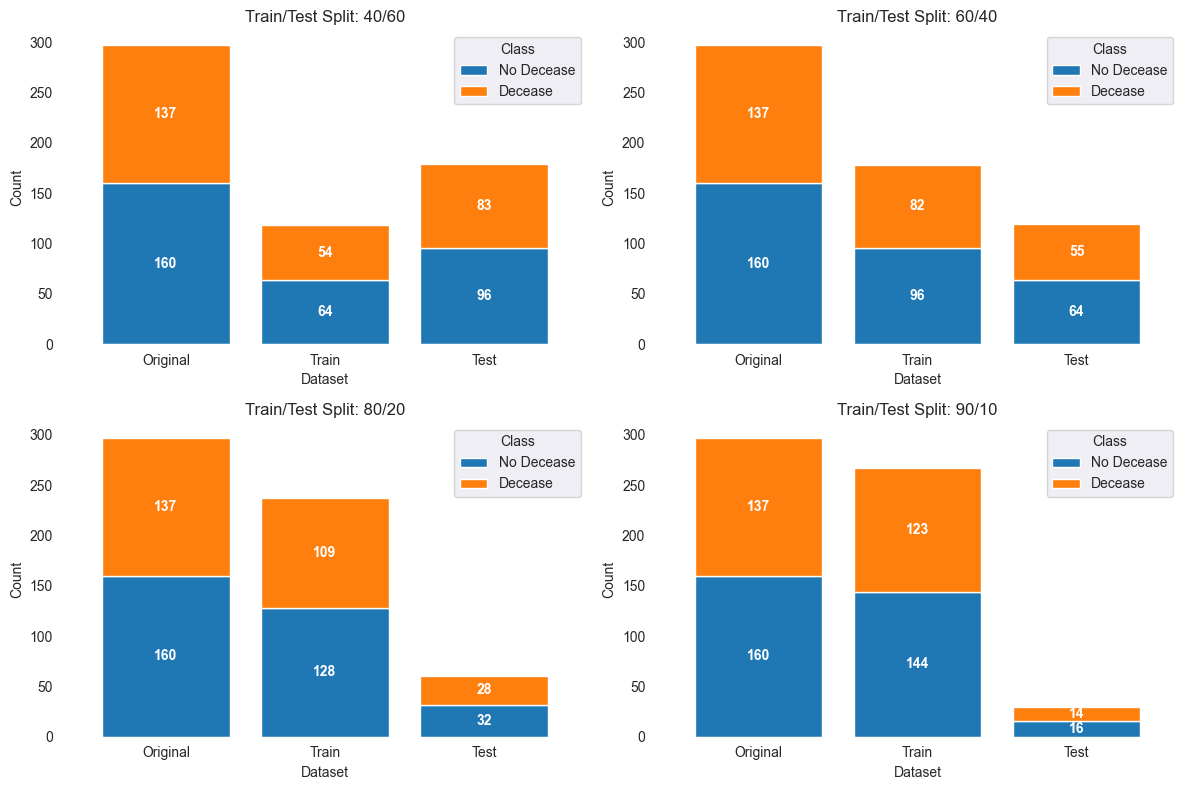

In [120]:
def visual_class_distribution():
	# Prepare figure with subplots and white background
	fig, axes = plt.subplots(2, 2, figsize=(12, 8), facecolor='white')
	axes = axes.flatten()

	for i, test_size in enumerate(split_ratios):
		_feature_train, _feature_test, _label_train, _label_test = dataset_splits[test_size]

		original_counts = dataset['target']['num'].value_counts() #.reindex(class_name)
		train_counts = pd.Series(_label_train['num']).value_counts() #.reindex(class_name)
		test_counts = pd.Series(_label_test['num']).value_counts() #.reindex(class_name)
		df = pd.DataFrame({
		    'Original': original_counts,
	        'Train': train_counts,
	        'Test': test_counts
		})

	    # plot stacked bar chart
		ax = axes[i]
		bars = df.T.plot(kind='bar', stacked=True, ax=ax, color=['#1f77b4', '#ff7f0e'], width=0.8)

		# add counters (text labels) to each segment
		for bar in bars.patches:
		    height = bar.get_height()
		    width = bar.get_width()
		    x = bar.get_x()
		    y = bar.get_y()
		    if height > 0:  # Only add label if segment exists
		        label = f'{int(height)}'
		        ax.text(
		            x + width / 2, y + height / 2, label,
		            ha='center', va='center', color='white', fontsize=10, fontweight='bold'
		        )
		# Customize plot
		ax.set_facecolor('white')
		# Set axes background to white
		ax.set_title(f'Train/Test Split: {round((1-test_size)*100)}/{round(test_size*100)}')
		ax.set_ylabel('Count')
		ax.set_xlabel('Dataset')
		ax.legend(title='Class', labels=class_name)
		ax.tick_params(axis='x', rotation=0)

	plt.tight_layout()
	plt.savefig(f"output/splits/{snake_cased_dataset_name}/split_distribution_{snake_cased_dataset_name}.png")
	plt.show()
visual_class_distribution()

### 3.2 Training and evaluate

In [121]:
from sklearn.tree import DecisionTreeClassifier

def build_id3_tree(feature_train, label_train, max_depth=None) -> DecisionTreeClassifier:
	dtc = DecisionTreeClassifier(criterion='entropy', random_state=random_seed, max_depth=max_depth)
	dtc.fit(feature_train, label_train) # train
	return dtc

### 3.3 Run all splits
> Required to run the code at [Section #3.2](#32-training-and-evaluate) before continue!



=== Heart Disease Train/Test 40/60 ===


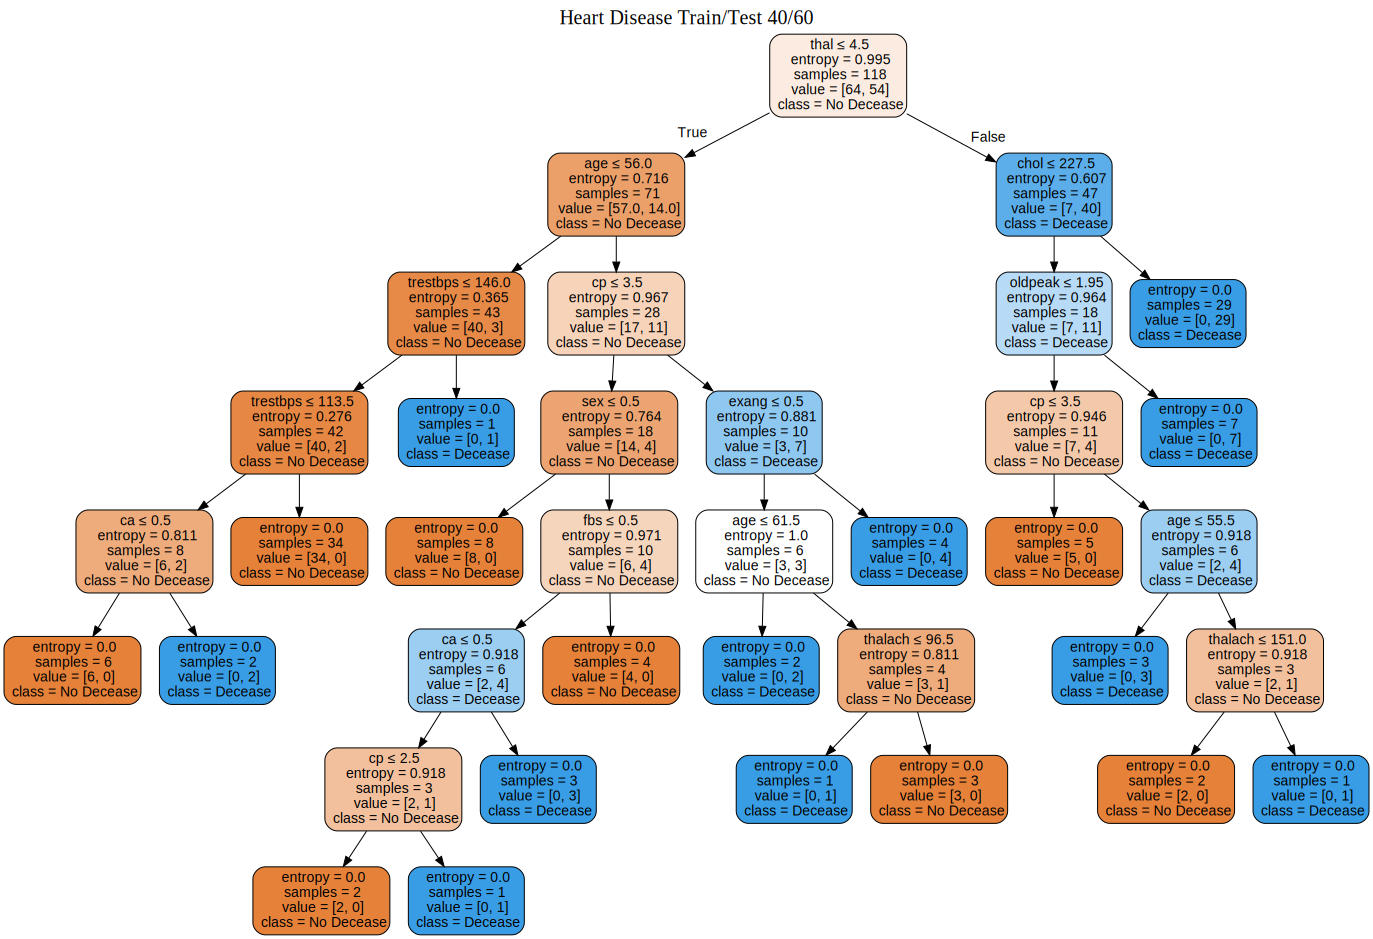

Saved decision tree visualization: output/splits/heart_disease/id3_heart_disease_40_60.svg
              precision    recall  f1-score   support

  No Decease       0.79      0.68      0.73        96
     Decease       0.68      0.80      0.73        83

    accuracy                           0.73       179
   macro avg       0.74      0.74      0.73       179
weighted avg       0.74      0.73      0.73       179



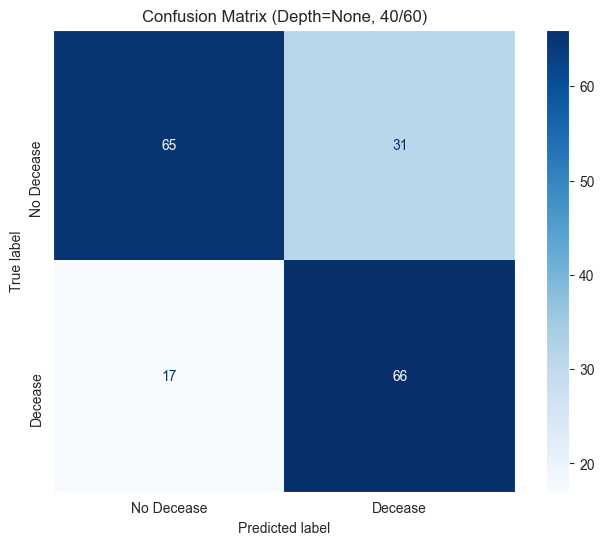

=== Heart Disease Train/Test 60/40 ===


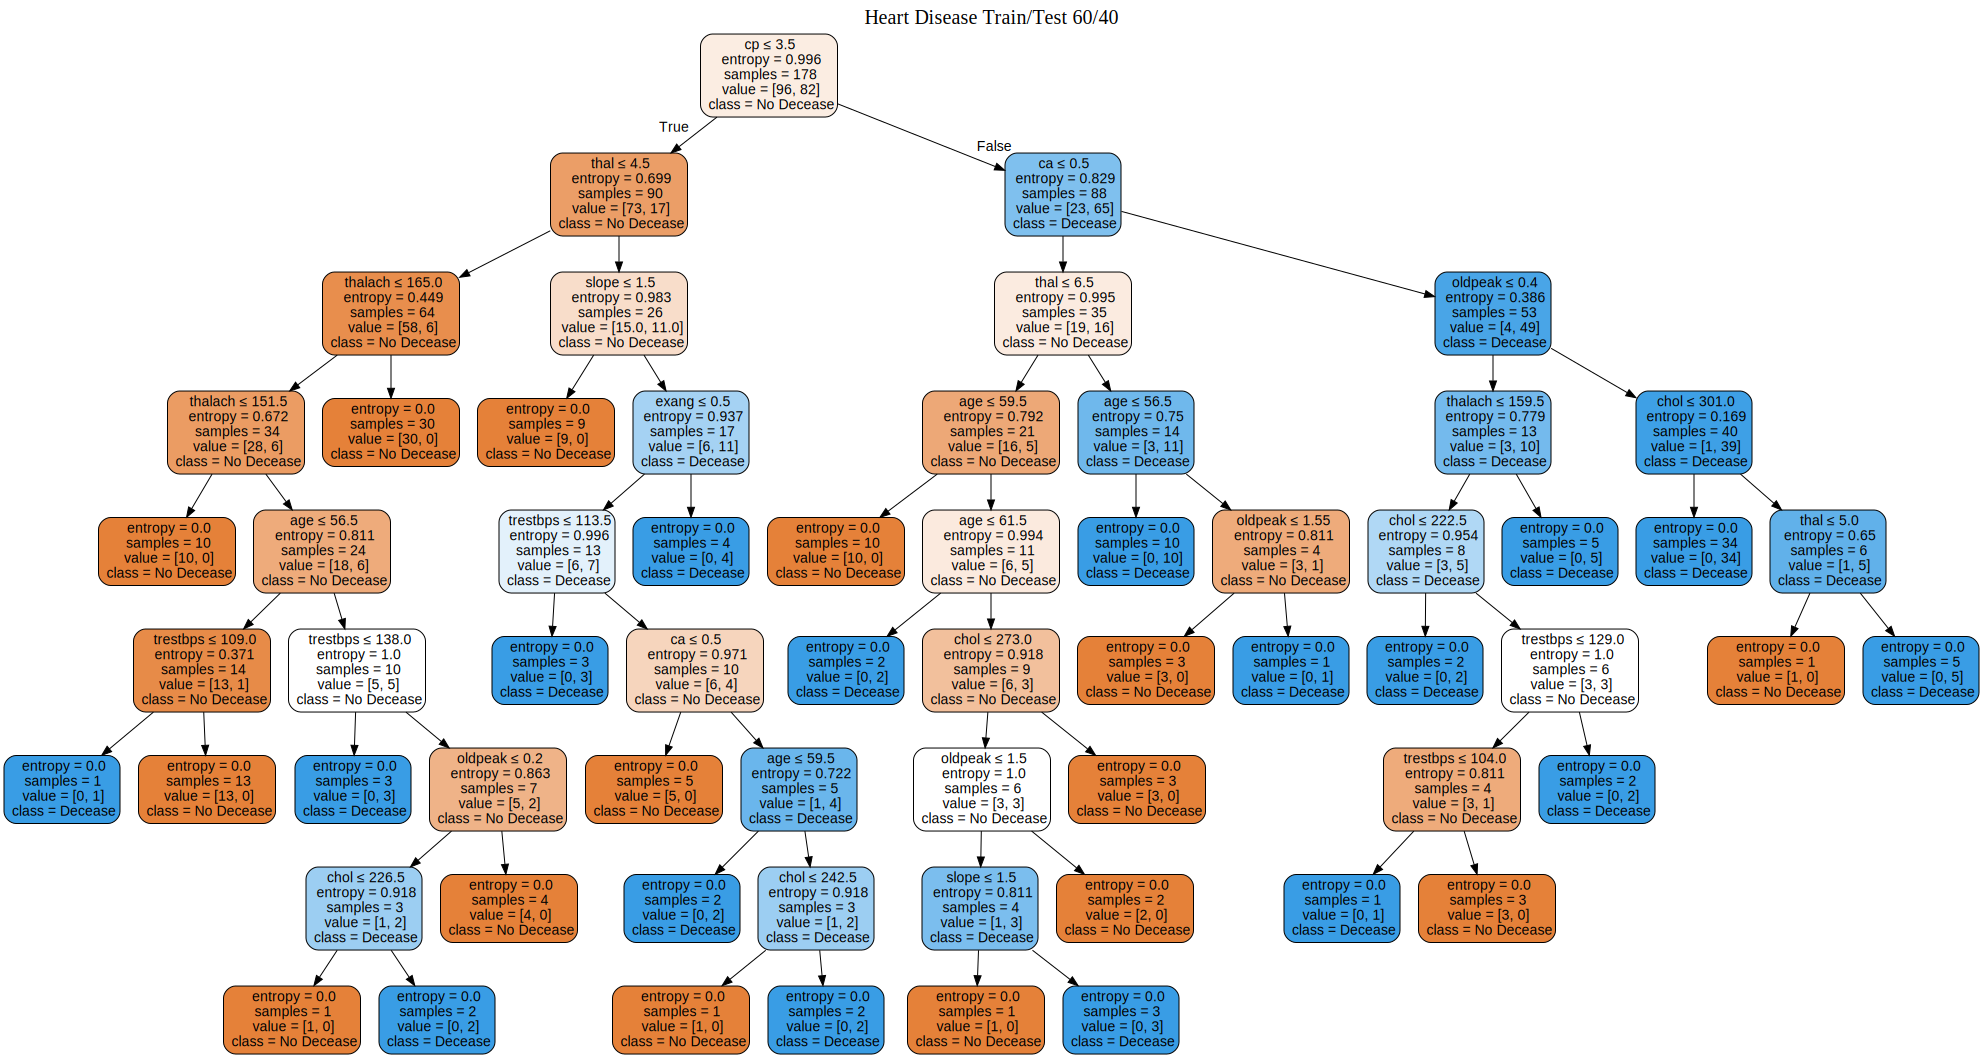

Saved decision tree visualization: output/splits/heart_disease/id3_heart_disease_60_40.svg
              precision    recall  f1-score   support

  No Decease       0.74      0.92      0.82        64
     Decease       0.87      0.62      0.72        55

    accuracy                           0.78       119
   macro avg       0.80      0.77      0.77       119
weighted avg       0.80      0.78      0.78       119



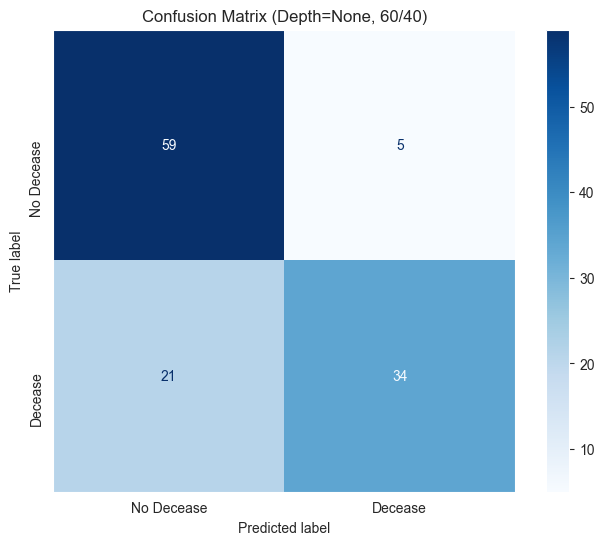

=== Heart Disease Train/Test 80/20 ===


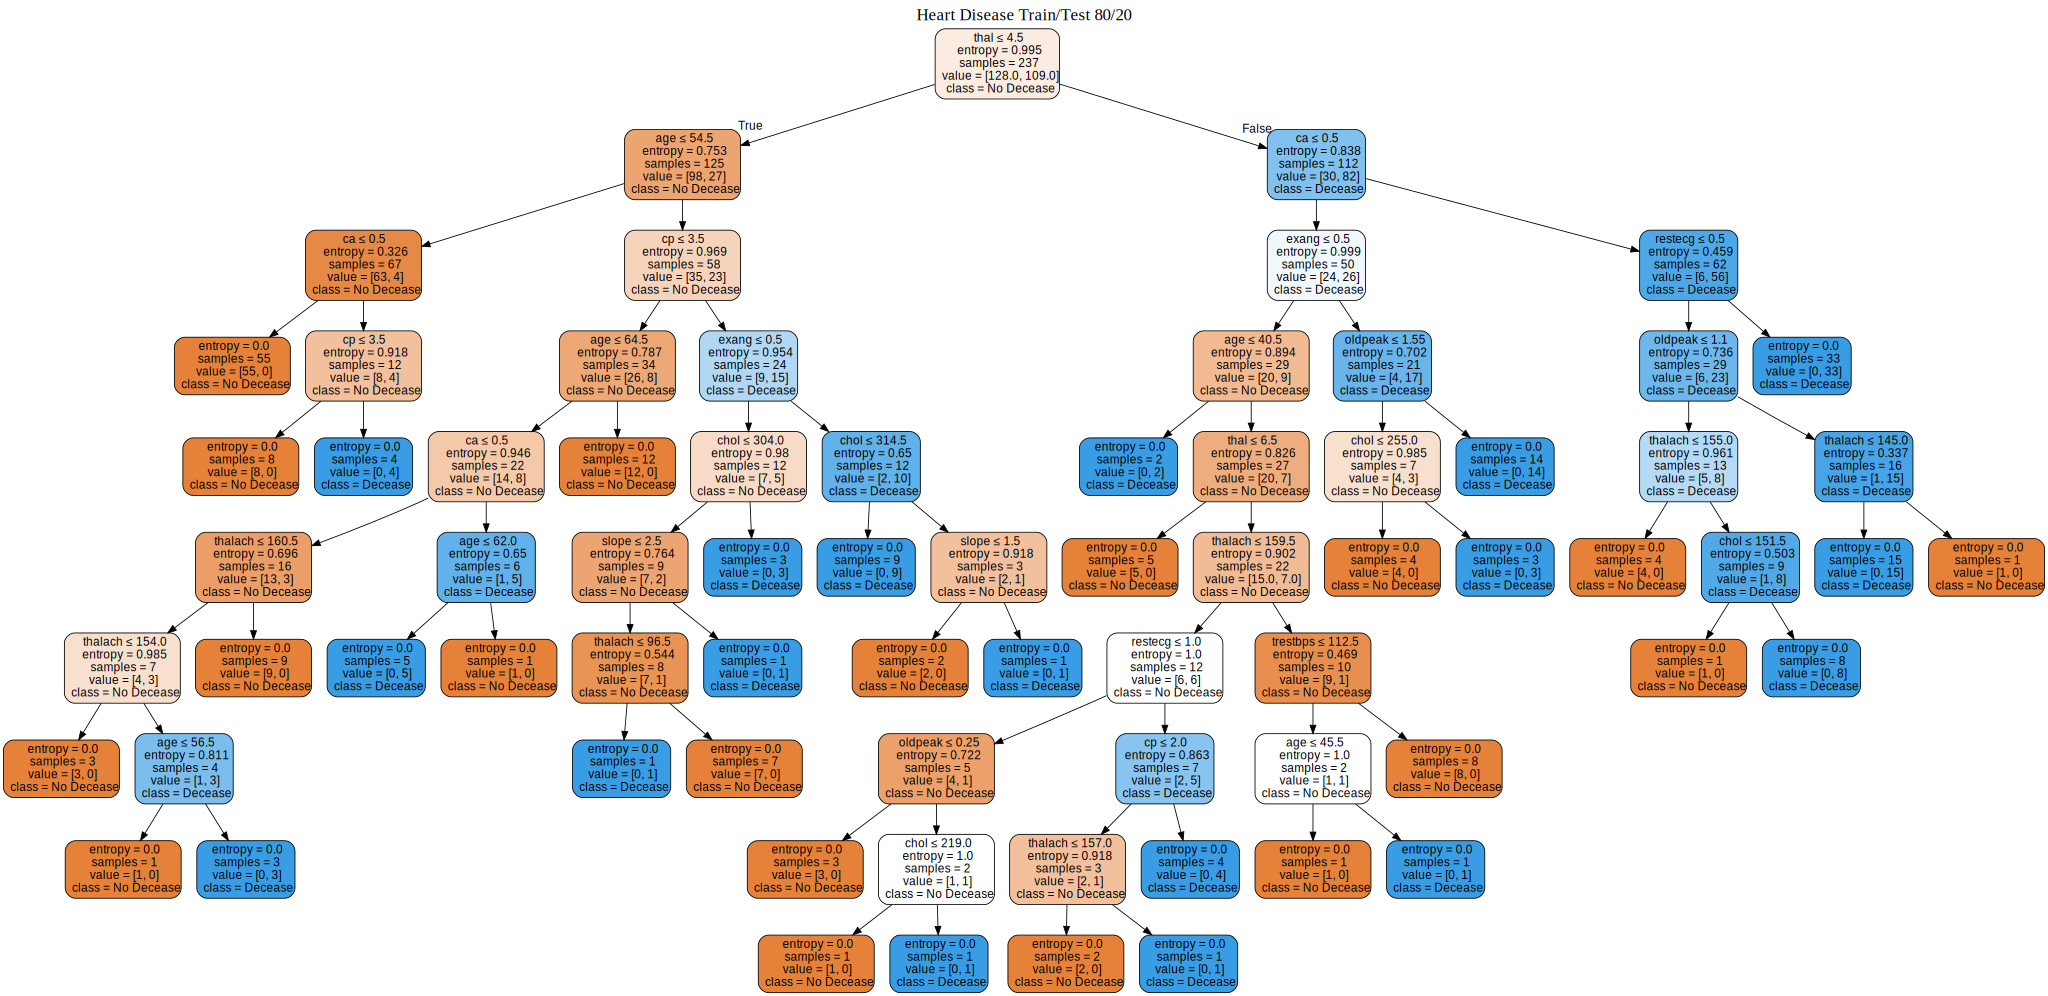

Saved decision tree visualization: output/splits/heart_disease/id3_heart_disease_80_20.svg
              precision    recall  f1-score   support

  No Decease       0.72      0.88      0.79        32
     Decease       0.81      0.61      0.69        28

    accuracy                           0.75        60
   macro avg       0.76      0.74      0.74        60
weighted avg       0.76      0.75      0.74        60



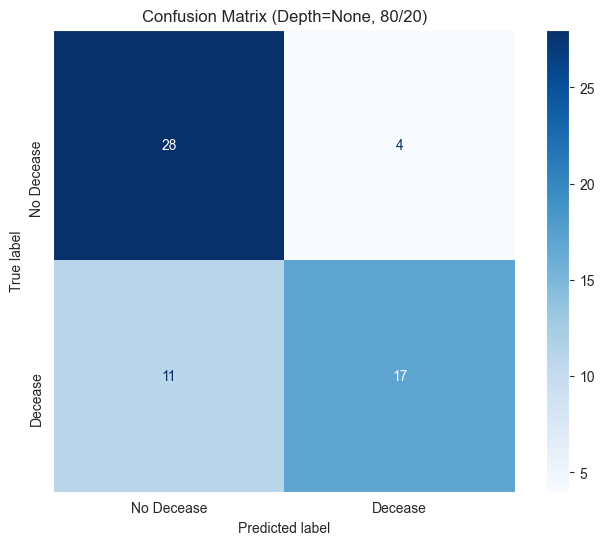

=== Heart Disease Train/Test 90/10 ===


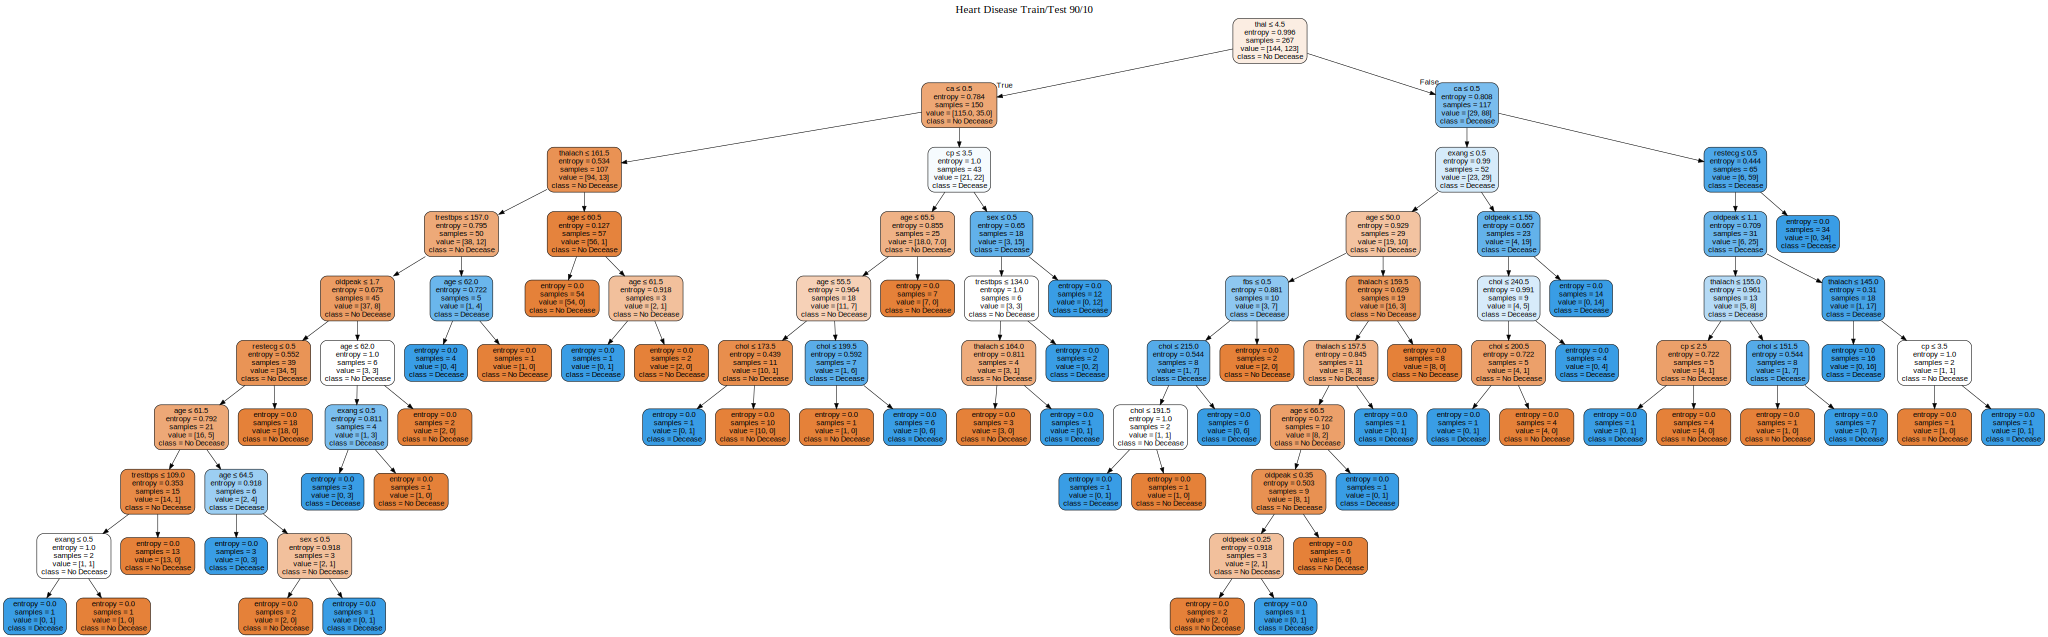

Saved decision tree visualization: output/splits/heart_disease/id3_heart_disease_90_10.svg
              precision    recall  f1-score   support

  No Decease       1.00      0.75      0.86        16
     Decease       0.78      1.00      0.88        14

    accuracy                           0.87        30
   macro avg       0.89      0.88      0.87        30
weighted avg       0.90      0.87      0.87        30



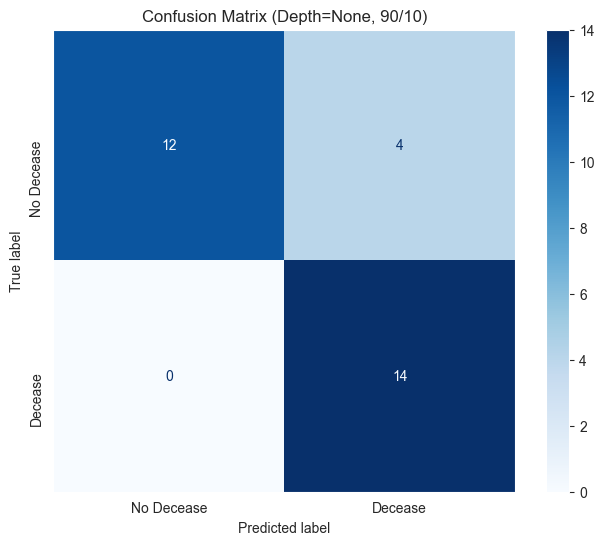

In [122]:
from sklearn.tree import plot_tree, export_graphviz
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import graphviz

def run_all_splits():
	with open(f"output/splits/{snake_cased_dataset_name}/log.txt", "w") as log_file:
		for test_size in split_ratios:
			_feature_train, _feature_test, _label_train, _label_test = dataset_splits[test_size]
			dtc = build_id3_tree(_feature_train, _label_train)
			# export decision tree to DOT format
			_title = f"{dataset_name} Train/Test {100 - round(test_size * 100)}/{round(test_size * 100)}"
			_dot_data = export_graphviz(dtc, feature_names=_feature_train.columns, class_names=class_name, filled=True, rounded=True, special_characters=True).replace('\n', f'\nlabel="{_title}"; labelloc=top; fontsize=20;\n', 1)
			_graph = graphviz.Source(_dot_data, format="svg")
			tee_print(f"=== {dataset_name} Train/Test {100 - round(test_size * 100)}/{round(test_size * 100)} ===", file=log_file)
			display(_graph)

			_output_file = f"output/splits/{snake_cased_dataset_name}/id3_{snake_cased_dataset_name}_{100 - round(test_size * 100)}_{round(test_size * 100)}"
			_graph.render(_output_file, cleanup=True, directory=".")
			tee_print(f"Saved decision tree visualization: {_output_file}.svg", file=log_file)
			_label_predict = dtc.predict(_feature_test) # predict the label of feature_test based on the tree
			tee_print(classification_report(_label_test, _label_predict, target_names=["No Decease", "Decease"]), file=log_file)

			cm = confusion_matrix(_label_test, _label_predict)
			disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_name)
			fig, ax = plt.subplots(figsize=(8, 6))
			disp.plot(ax=ax, cmap='Blues')
			plt.title(f"Confusion Matrix (Depth=None, {100 - round(test_size * 100)}/{round(test_size * 100)})")
			plt.yticks(rotation=90)
			plt.grid(False)
			plt.savefig(f"output/splits/{snake_cased_dataset_name}/confusion_matrix_{snake_cased_dataset_name}_{100 - round(test_size * 100)}_{round(test_size * 100)}.png", dpi=150)
			plt.show()
run_all_splits()

### 3.4 Depth analysis


Max Depth: None - Actual Depth: 12 - Accuracy: 0.7167


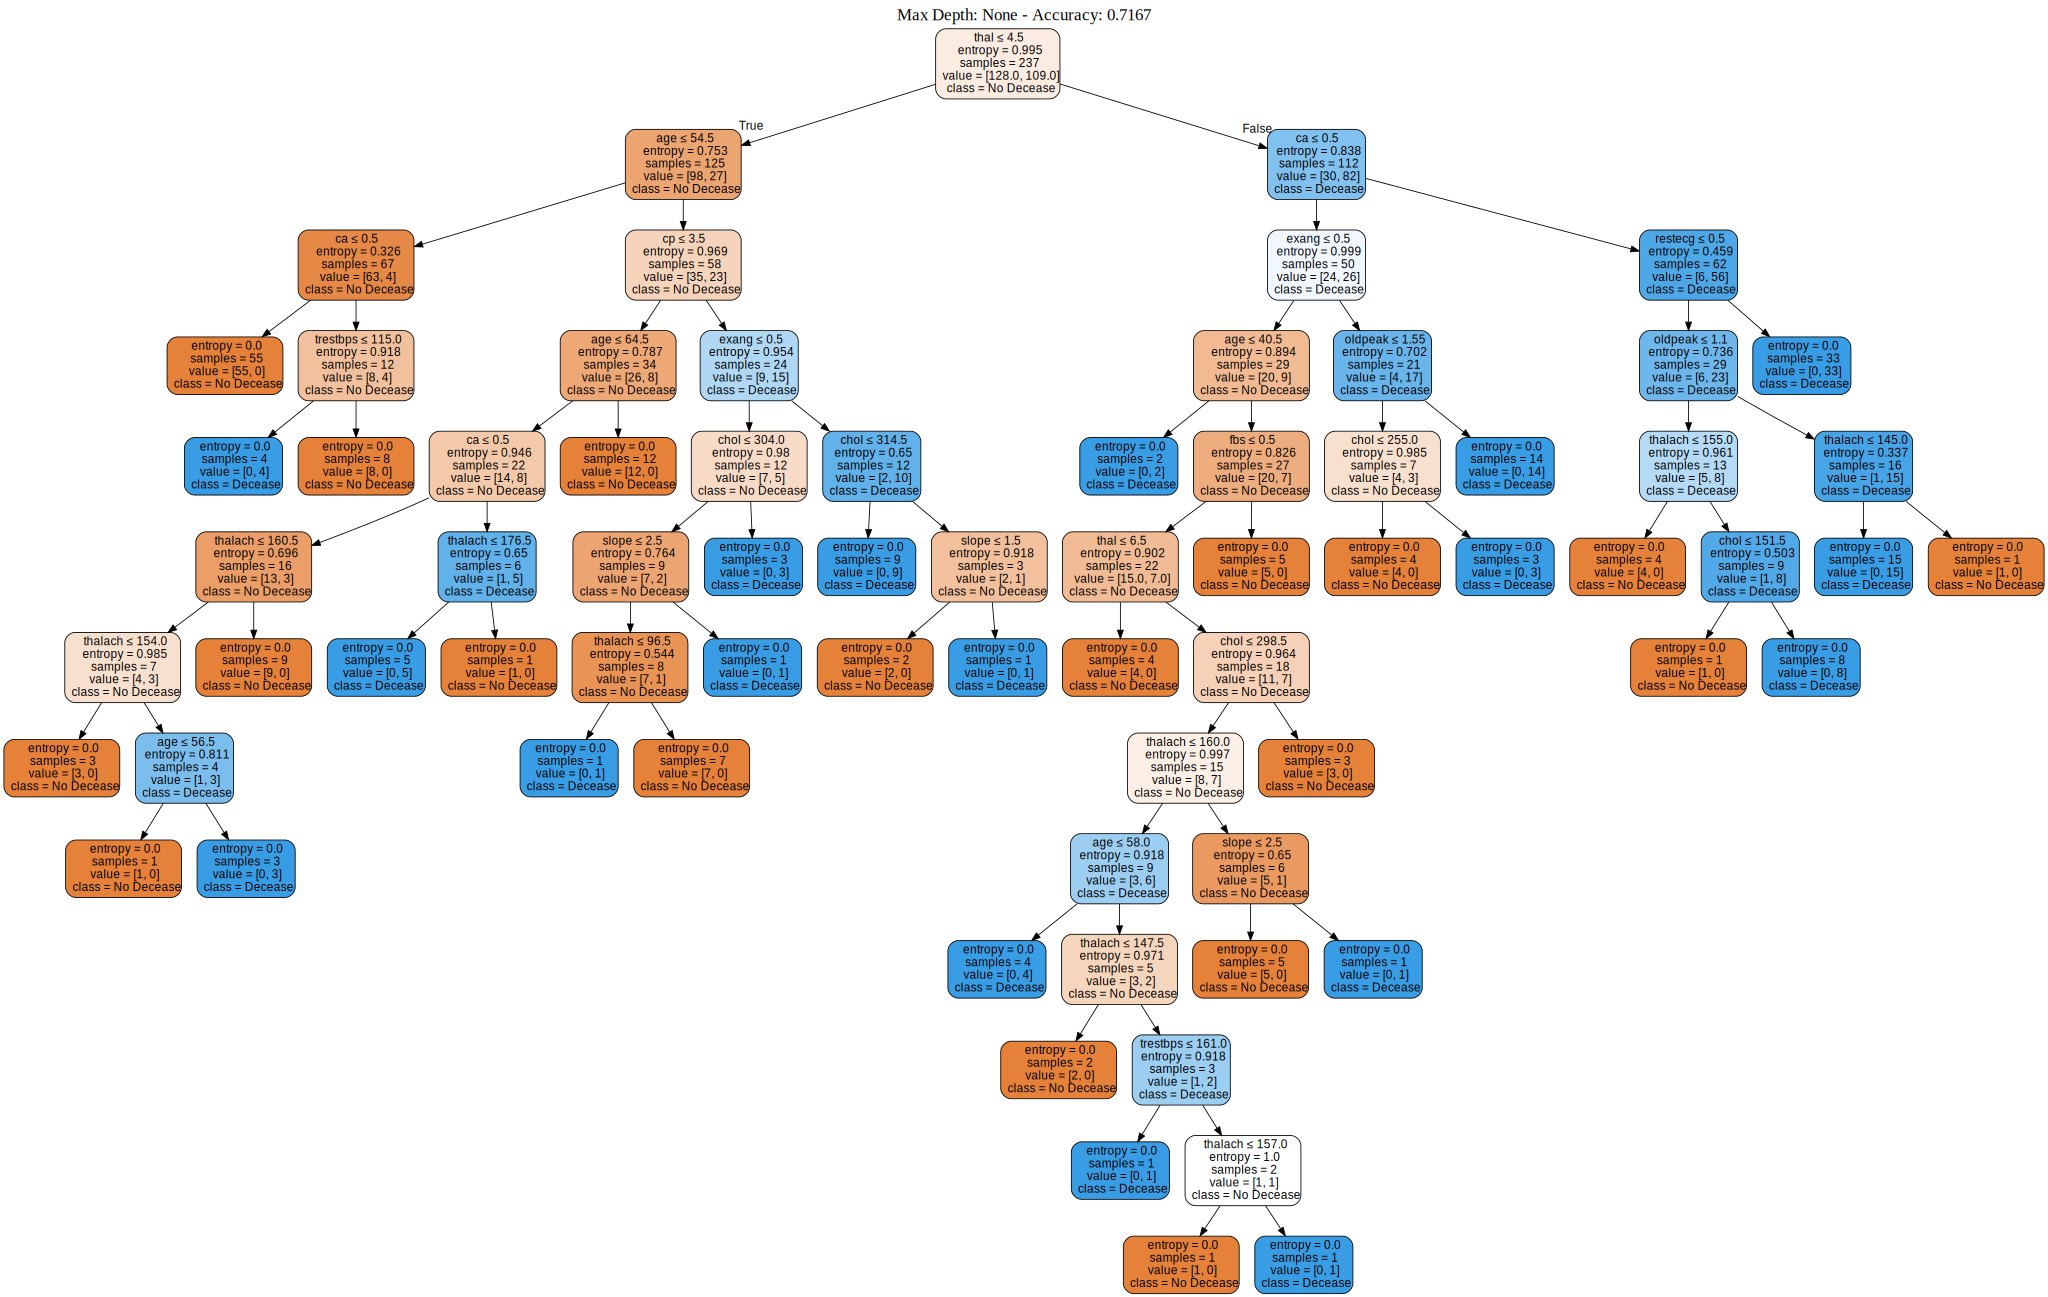

Saved decision tree visualization: output/depth/heart_disease/id3_heart_disease_80_20_depth_none.svg
-====================================================-

Max Depth: 2 - Actual Depth: 2 - Accuracy: 0.7833


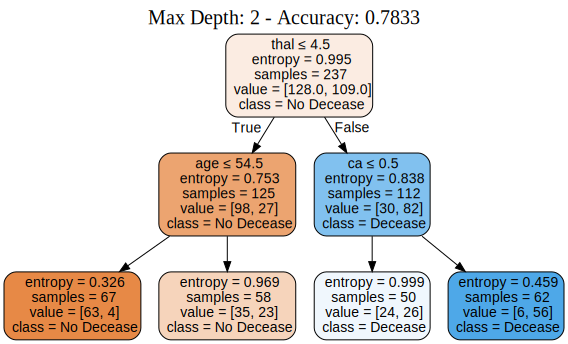

Saved decision tree visualization: output/depth/heart_disease/id3_heart_disease_80_20_depth_2.svg
-====================================================-

Max Depth: 3 - Actual Depth: 3 - Accuracy: 0.7833


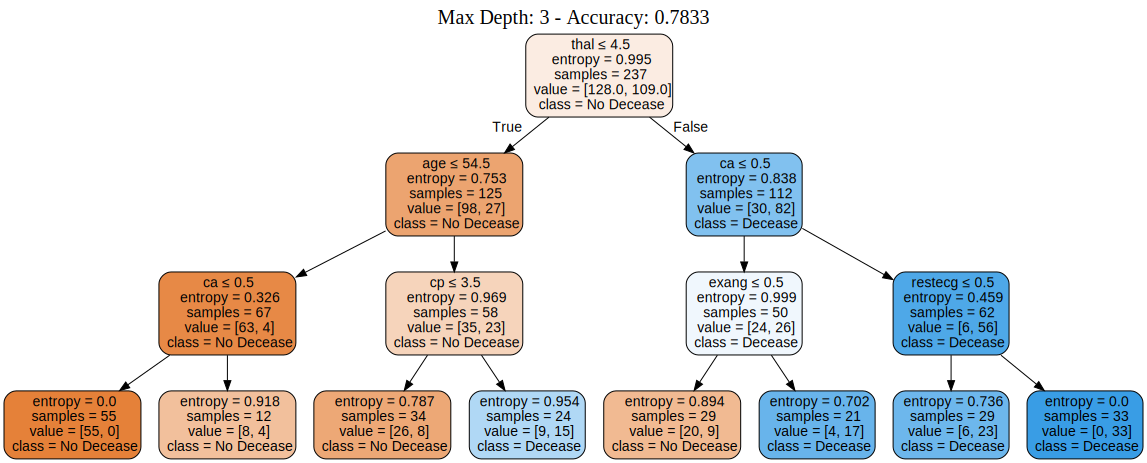

Saved decision tree visualization: output/depth/heart_disease/id3_heart_disease_80_20_depth_3.svg
-====================================================-

Max Depth: 4 - Actual Depth: 4 - Accuracy: 0.8167


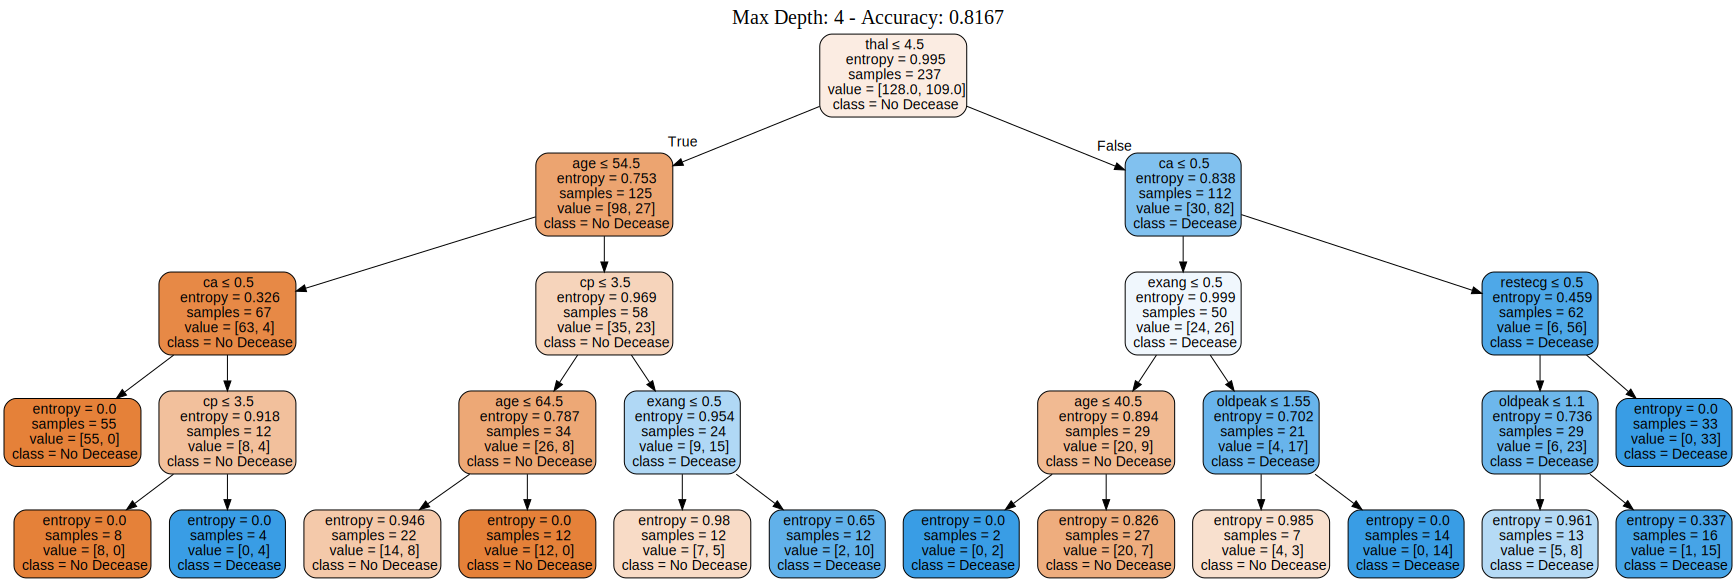

Saved decision tree visualization: output/depth/heart_disease/id3_heart_disease_80_20_depth_4.svg
-====================================================-

Max Depth: 5 - Actual Depth: 5 - Accuracy: 0.7333


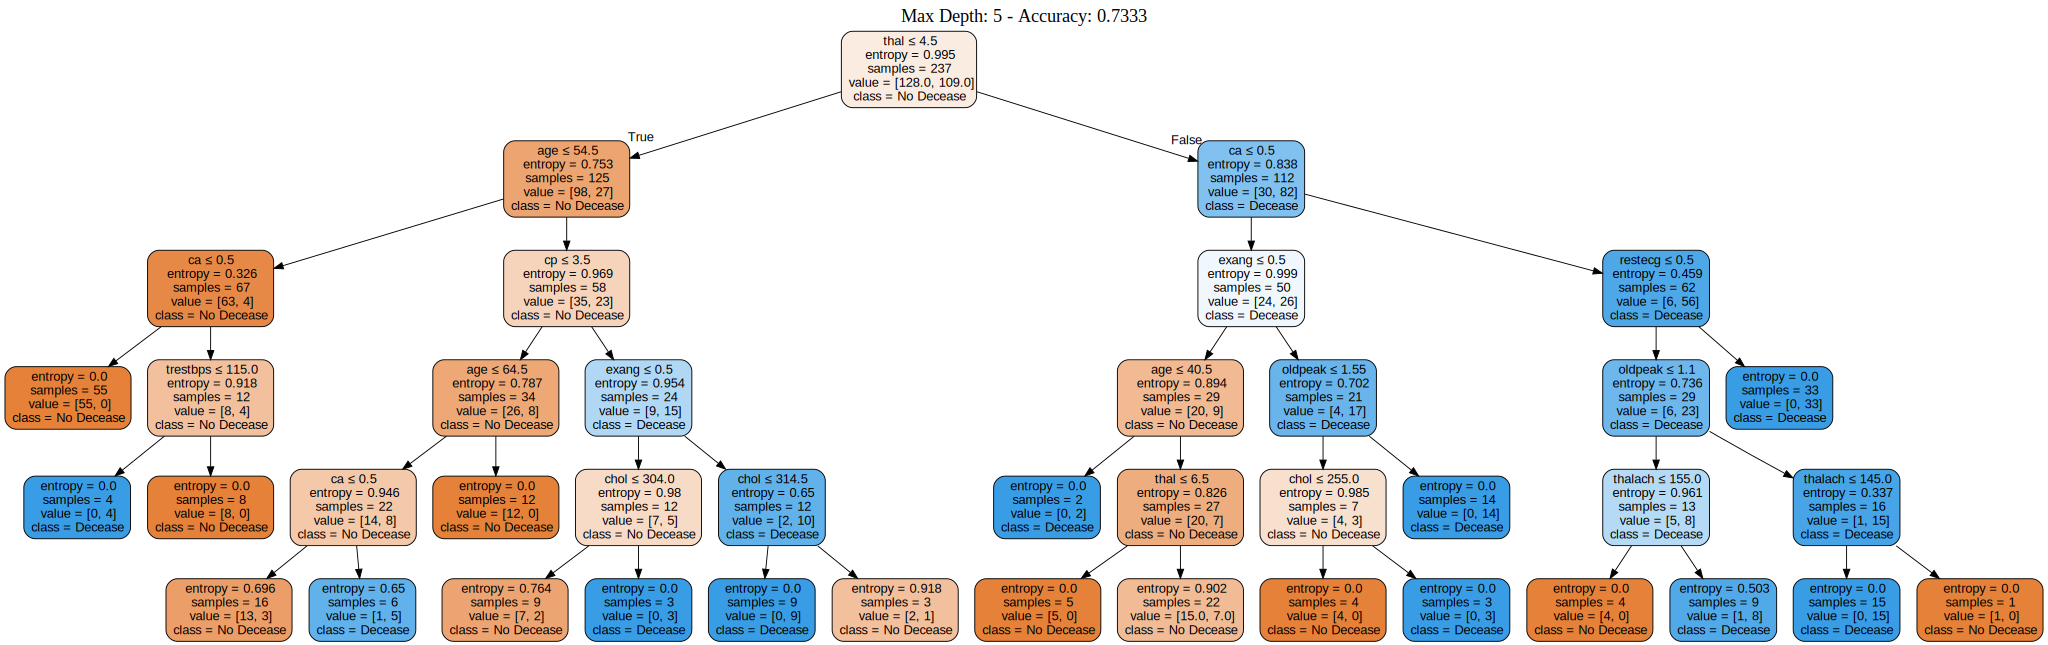

Saved decision tree visualization: output/depth/heart_disease/id3_heart_disease_80_20_depth_5.svg
-====================================================-

Max Depth: 6 - Actual Depth: 6 - Accuracy: 0.7500


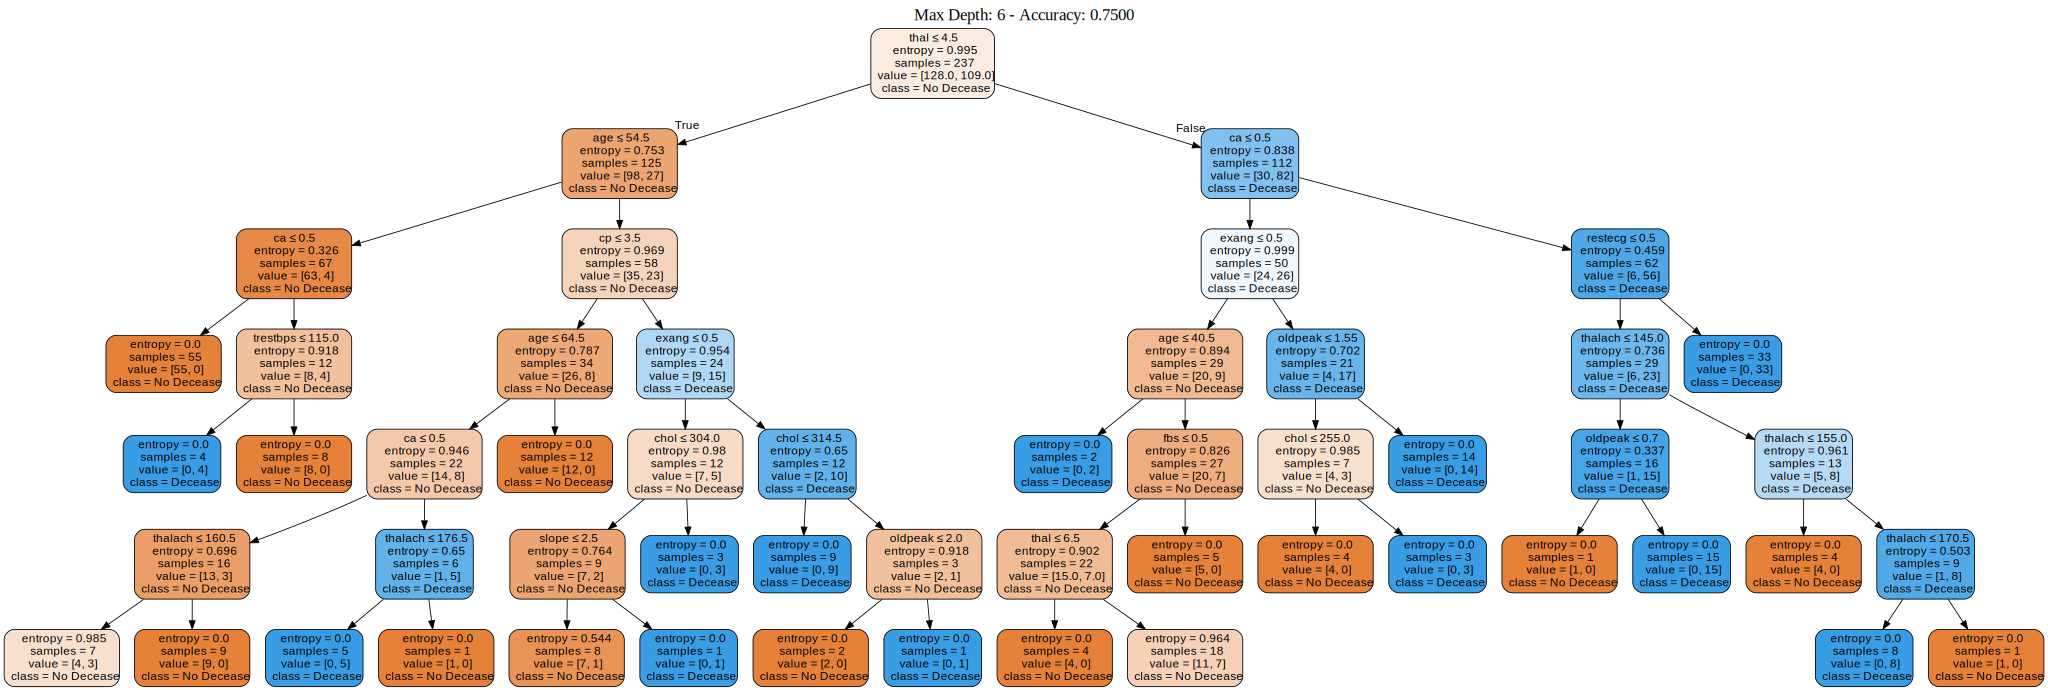

Saved decision tree visualization: output/depth/heart_disease/id3_heart_disease_80_20_depth_6.svg
-====================================================-

Max Depth: 7 - Actual Depth: 7 - Accuracy: 0.7167


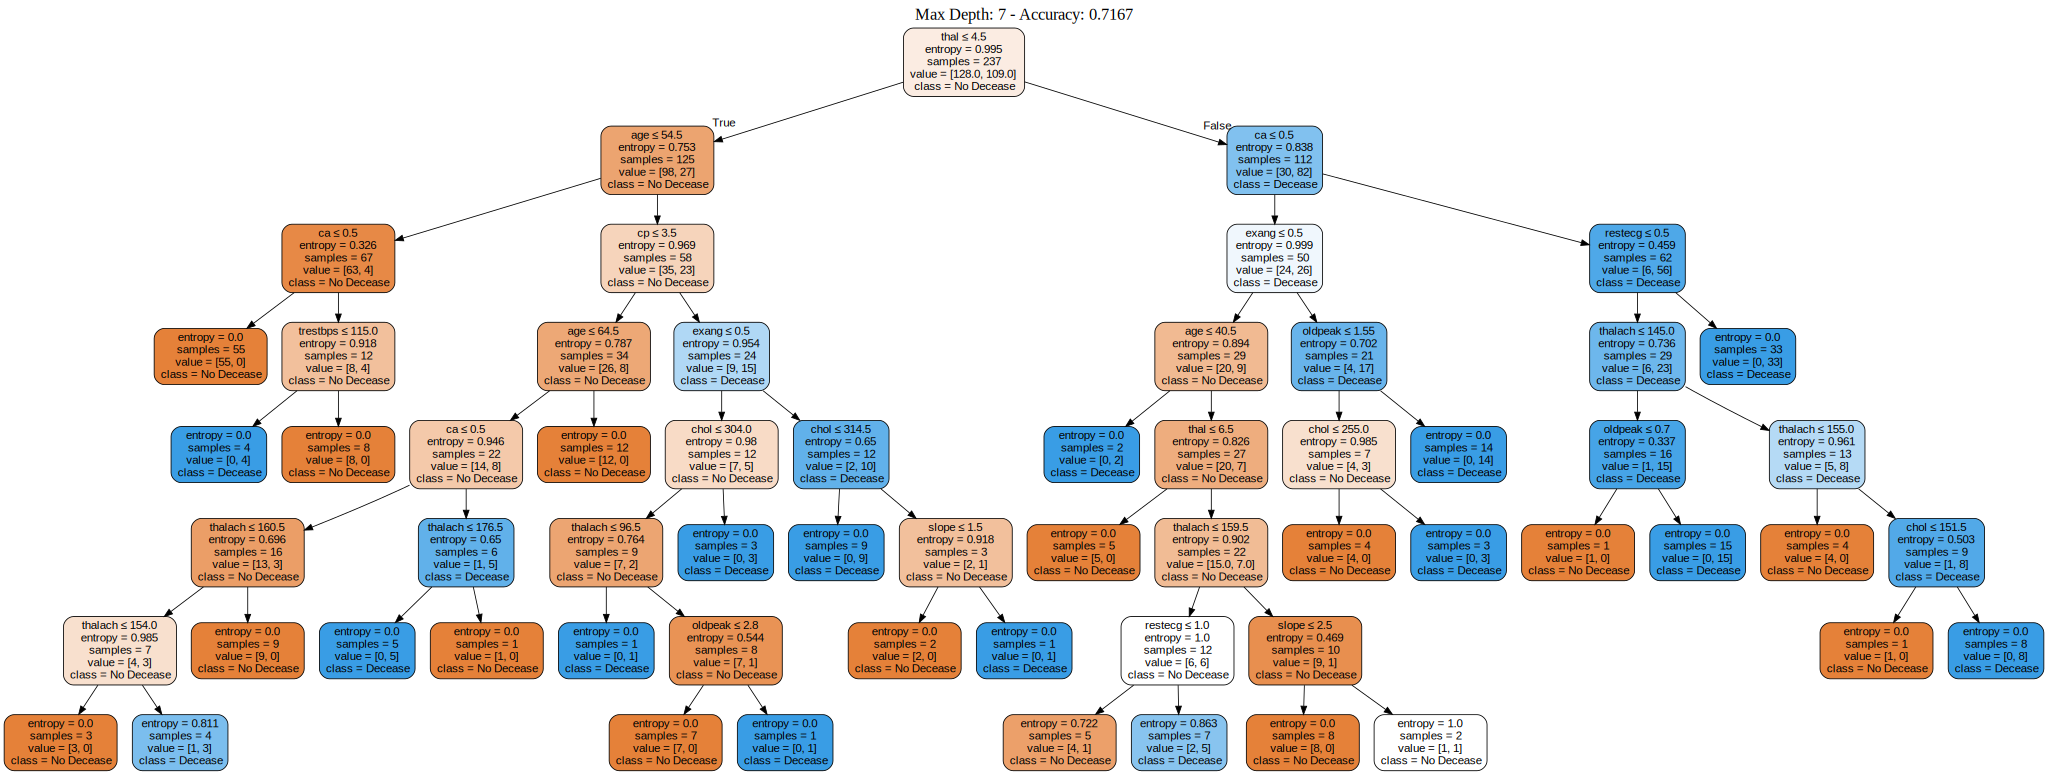

Saved decision tree visualization: output/depth/heart_disease/id3_heart_disease_80_20_depth_7.svg
-====================================================-



In [123]:
from sklearn.metrics import accuracy_score
from sklearn.tree import export_graphviz
import graphviz
from IPython.display import display

depths = [None, 2, 3, 4, 5, 6, 7]
accuracies = []

with open(f"output/depth/{snake_cased_dataset_name}/log.txt", "w") as log_file:
	feature_train, feature_test, label_train, label_test = dataset_splits[0.2]
	for d in depths:
		# train decision tree with specified max_depth
		dtc = build_id3_tree(feature_train, label_train, max_depth=d)
		result_depth = dtc.get_depth()
		label_predict = dtc.predict(feature_test)
		acc = accuracy_score(label_test, label_predict)
		accuracies.append(acc)

		tee_print(f"Max Depth: {d} - Actual Depth: {result_depth} - Accuracy: {acc:.4f}", file=log_file)
		sys.stdout.flush()

		# export decision tree to DOT format
		title = f"Max Depth: {d} - Accuracy: {acc:.4f}"
		_dot_data = export_graphviz(dtc, feature_names=feature_train.columns, class_names=class_name, filled=True, rounded=True, special_characters=True).replace('\n', f'\nlabel="{title}"; labelloc=top; fontsize=20;\n', 1)
		_graph = graphviz.Source(_dot_data, format="svg")

		_output_file = f"output/depth/{snake_cased_dataset_name}/id3_{snake_cased_dataset_name}_80_20_depth_{d if d is not None else "none"}"
		_graph.render(_output_file, cleanup=True, directory=".")
		display(_graph)
		tee_print(f"Saved decision tree visualization: {_output_file}.svg", file=log_file)
		tee_print(f"-====================================================-\n", file=log_file)

#### 3.4.a Charts showing correlation between max depth and accuracy

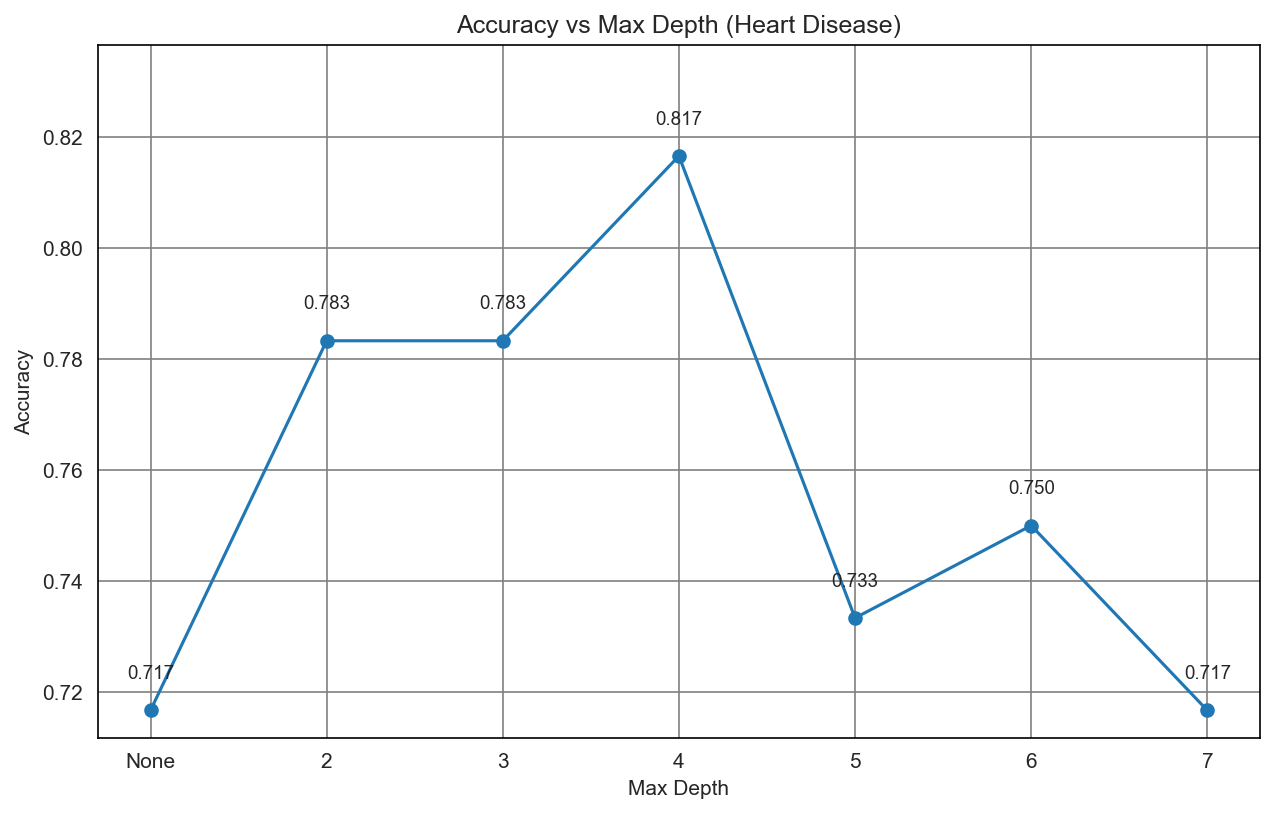

  max_depth  Accuracy
0      None  0.716667
1         2  0.783333
2         3  0.783333
3         4  0.816667
4         5  0.733333
5         6  0.750000
6         7  0.716667


In [124]:
# Plot accuracies
depth_name = [str(d) for d in depths]
plt.figure(figsize=(10, 6), dpi=150)
plt.plot(depth_name, accuracies, marker='o')
plt.title(f"Accuracy vs Max Depth ({dataset_name})")
plt.xlabel("Max Depth")
plt.ylabel("Accuracy")

plt.ylim(top=max(accuracies) + 0.02)  # add a bit of headroom
# add value labels above each point
for x, y in zip(depth_name, accuracies):
	plt.text(x, y + 0.005, f"{y:.3f}", ha='center', va='bottom', fontsize=9)

plt.grid(True, color='gray')
plt.gca().set_facecolor('white') # set white background for the axes
plt.gca().spines['top'].set_color('black')
plt.gca().spines['top'].set_visible(True)
plt.gca().spines['right'].set_color('black')
plt.gca().spines['right'].set_visible(True)
plt.gca().spines['bottom'].set_color('black')
plt.gca().spines['bottom'].set_visible(True)
plt.gca().spines['left'].set_color('black')
plt.gca().spines['left'].set_visible(True)

plt.savefig(f"output/depth/{snake_cased_dataset_name}/accuracy_{snake_cased_dataset_name}.png", dpi=150)
plt.show()
accuracy_table = pd.DataFrame({'max_depth': depth_name, 'Accuracy': accuracies})
with open(f"output/depth/{snake_cased_dataset_name}/log.txt", "a") as log_file:
	tee_print(accuracy_table, file=log_file)